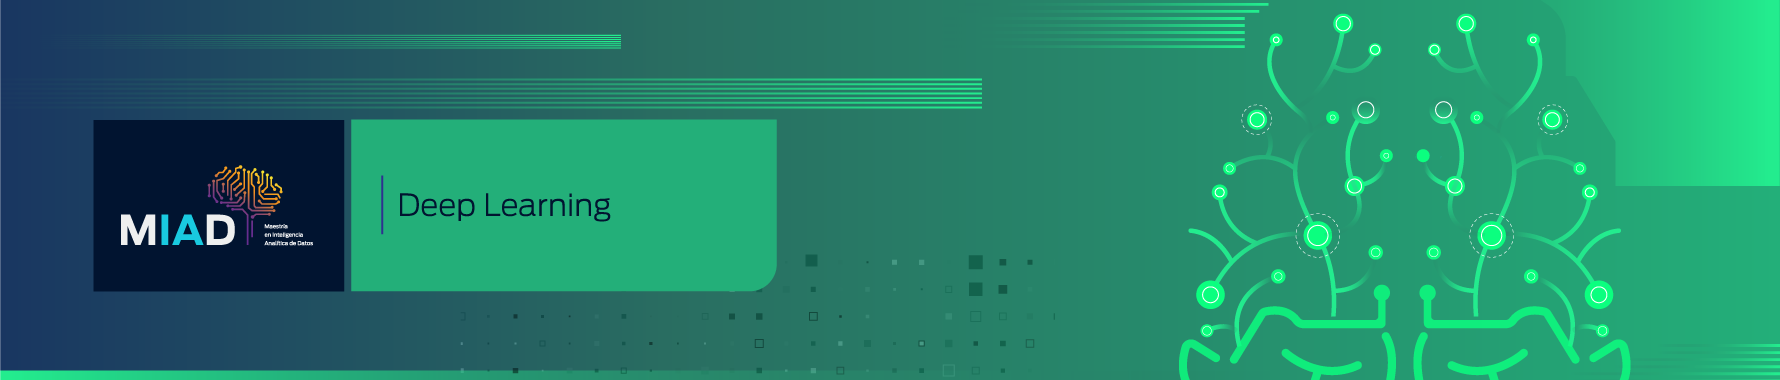

# Aplicaciones de Redes Convolucionales

## Reconocimiento de rostros 

### Propósito 
A diferencia de los problemas que hemos tratado hasta ahora en Deep Learning, como la identificación de un objeto específico en una imagen, el reconocimiento de rostros trae muchos retos adicionales:
*   En primer lugar, el algoritmo debe ver una imagen y encontrar/ubicar todas las caras presentes en esta.
*   Luego, debe enfocarse en cada cara y debe poder reconocer que, sin importar el tamaño, ángulo del rostro, mala iluminación, entre otros, corresponde a una cara entrenada previamente. 
*   Después, debe ser capaz de seleccionar las características relevantes de la cara que le permitan al algoritmo de Deep Learning diferenciar a unas personas de otras.
*   Finalmente, debe comparar esas características con las de las personas que ya se conocen para identificar el nombre de una persona.

Este proceso, que es automático en seres humanos, puede ser implementado con la ayuda del Deep Learning a través de una serie de pasos que serán descritos en este _notebook_. Posteriormente, se realizará una aplicación del algoritmo propuesto el cual requerirá del uso de recursos de GPU a través de Google Colaboratory. Finalmente, se plantea una actividad que debe ser entregada y será evaluada por el personal.

### Instrucciones generales
1. Para desarrollar la parte calificada del notebook, lo deberán descargar a Google Colaboratory para que lo puedan trabajar grupalmente utilizando los recursos de GPU.

2. Para que la actividad sea calificada, deberán subir este mismo archivo con la extensión ".ipynb" y los archivos de soporte (imágenes) a la actividad de "entrega calificada por el personal" correspondiente a este caso.

3. El archivo que suban debe poder ejecutarse en Google Colaboratory cuando sea descargado por el tutor.

### Librerías a importar
Para las tres primeras secciones, no se requiere del uso de GPU, por lo que se pueden ejecutar las siguientes líneas en la imagen de Jupyter Notebook disponible en Coursera. A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este cuaderno:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from skimage.feature import hog
from skimage import exposure
from skimage import io
import dlib
#Las siguientes dos líneas evitan la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import tensorflow as tf

### 1. Encontrando los rostros

Para iniciar el proceso de detección de rostros, debemos importar la librería de OpenCV, _cv2_, y posteriormente hacer carga de la imagen disponible en Wikimedia Commons. La imagen original tiene una resolución bastante alta que no es requerida para los pasos que ejecutaremos a continuación, por lo tanto la reescalaremos utilizando la función `cv2-resize()`:

In [ ]:
# Lectura de la imagen
image = cv2.imread("Albert_Einstein_Head.jpg")

# Reescalado de la imagen
scale_percent = 20 # porcentaje del tamaño original
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('einstein_scaled.jpg', image)

plt.figure(dpi=150)
#Para mostrar la imagen correctamente utilizando matplotlib, se deben reorganizar los canales de OpenCV de BGR a RGB.
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

Uno de los métodos más eficientes y confiables para la detección de rostros es el uso de histogramas de gradientes orientados (_HOG_ por sus siglas en inglés). Como primer paso, este algoritmo revisa cada pixel de la imagen y la compara con sus alrededores para identificar la dirección hacia la cual se encuentra un pixel más oscuro. Sobre el pixel se dibuja una flecha que indica esta dirección:

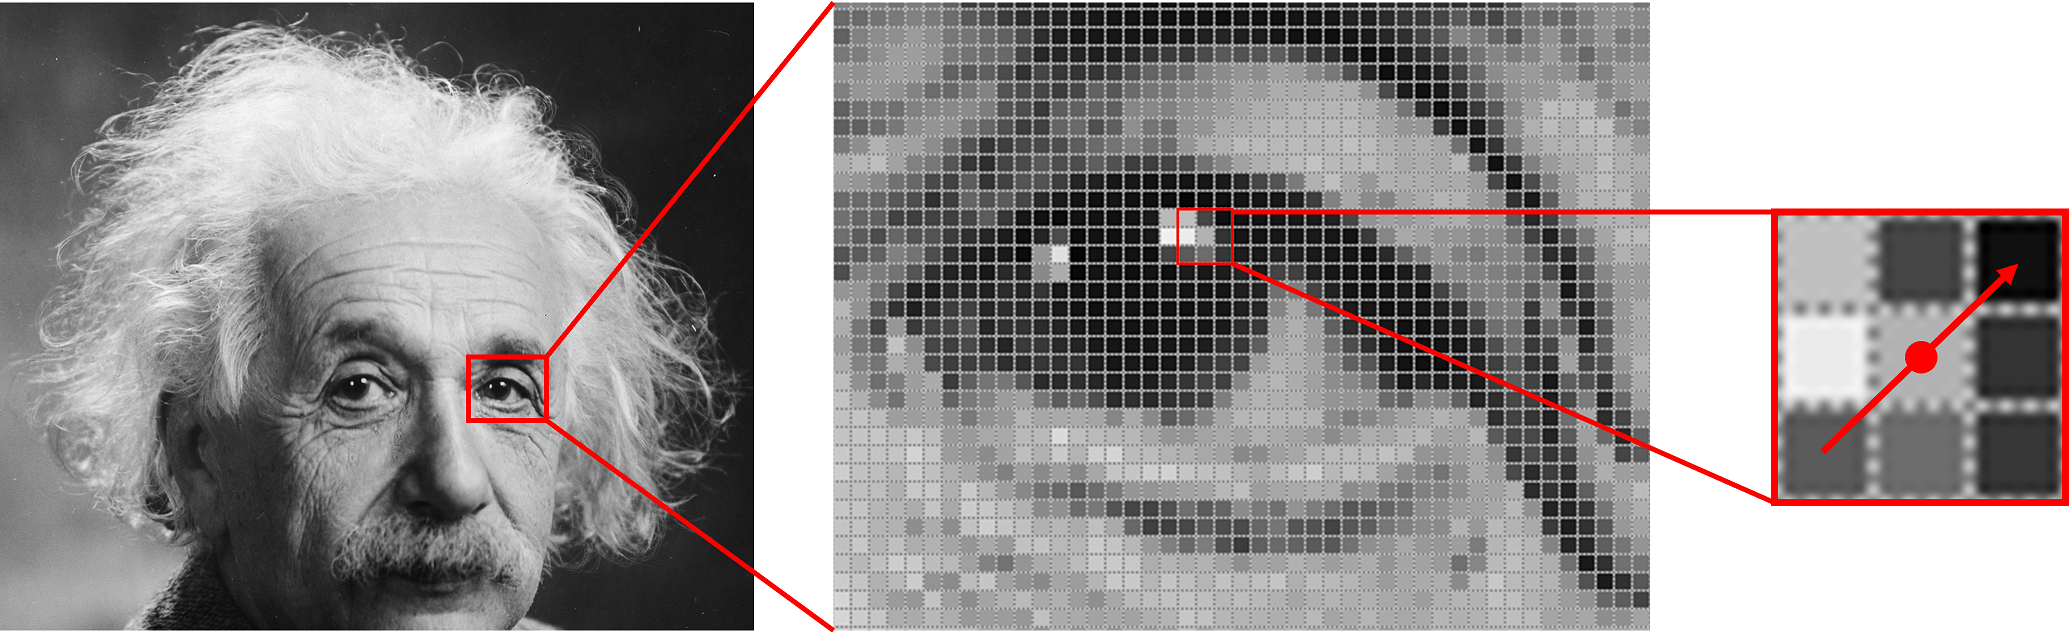

Estas flechas son los _gradientes_ de cada pixel. Al realizar esta operación en toda la imagen, se reemplaza la información original de pixeles a gradientes, mostrando la dirección en la cuál la imagen pasa de claro a oscuro. La utilidad de analizar la imagen con respecto a los gradientes y no los valores de los pixeles es que permite identificar las caras de una misma persona sin importar el brillo de la imagen. Dado que se usa la dirección en la cual cambia el brillo, imagenes más claras o oscuras tendrán la misma representación, facilitando la detección del rostro.

Luego de estimar los gradientes, el algoritmo simplifica la información para tener una idea básica de cómo es el flujo de claro a oscuro para identificar patrones básicos en la imagen. Para esto, en vez de guardar las direcciones para cada pixel, se divide la imagen en pequeñas matrices cuadradas (de $16\times 16$ pixeles, generalmente) y se realiza un histograma de los gradientes de esos pixeles para identificar las direcciones más frecuentes.

Con el siguiente código se puede obtener una representación tipo _HOG_ de la imagen que estamos analizando:

In [ ]:
#Se genera la representación HOG de la imagen (toma unos segundos)
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

#Se grafica la imagen original junto a la representación HOG
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Imagen de entrada')
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histograma de Gradientes Orientados (HOG)')
plt.show()

Como resultado se obtiene una representación simple de la imagen original que captura la estructura básica del rostro. Con esta información simplificada, el algoritmo de detección puede comparar rápidamente con patrones HOG de caras pre-entranadas y así extraer la sección de la imagen que posee el rostro para la siguiente fase del algoritmo.

### 2. Identificando puntos de referencia en el rostro.

Ahora que las caras están aisladas, se debe tratar con el problema de que, para un computador, la misma cara en diferentes ángulos se reconocen como diferentes rostros. Por lo tanto, se debe alterar la cara a reconocer de forma que quede de frente y se pueda comparar directamente con rostros previamente entrenados. Para esto se implementa un algoritmo que estime puntos de referencia (_landmarks_) en el rostro. La idea básica consiste en reconocer 68 puntos específicos que representen el borde externo de cada ojo, el eje interno de cada ceja, la parte superior del mentón, el contorno de los labios y la nariz:

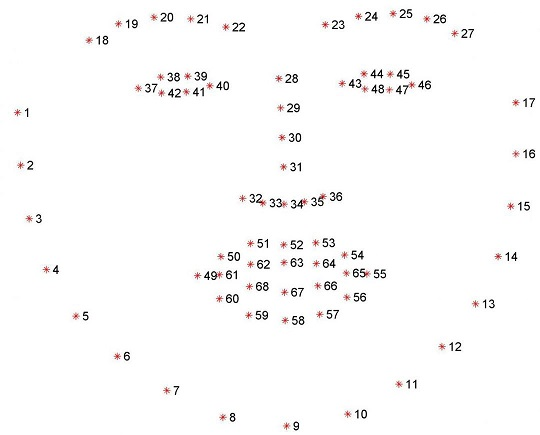

Con el siguiente código se pueden reconocer los puntos de referencia de la imagen de interés. Las siguientes líneas requieren la descarga de un paquete adicional de `dlib`, por lo que la ejecución puede tomar unos segundos.

In [ ]:
dataset_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=False)
!mv ~/.keras/datasets/shape_predictor_68_face_landmarks.dat.bz2 ./
!bunzip2 shape_predictor_68_face_landmarks.dat.bz2
predictor_model = "shape_predictor_68_face_landmarks.dat"

In [ ]:
# Se crea un detector de caras a través del método HOG del paquete dlib
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)

# Carga de la imagen
file_name = 'einstein_scaled.jpg'
image = io.imread(file_name)

# Se ejecuta el detector HOG sobre la imagen
detected_faces = face_detector(image, 1)

print("Found {} faces in the image".format(len(detected_faces)))

# Se analiza cada cara detectada i
for i, face_rect in enumerate(detected_faces):
    # Las caras detectadas son retornadas como un objeto con las coordenadas
    # de los bordes superiores, izquierdo, derecho e inferior
    print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()))
    
    # Se obtienen los puntos de referencia del rostro
    pose_landmarks = face_pose_predictor(image, face_rect)
    
    # Se grafican los landmarks sobre la imagen original
    for j in range(68):
        image[pose_landmarks.part(j).y - 3: pose_landmarks.part(j).y + 3, pose_landmarks.part(j).x - 3: pose_landmarks.part(j).x + 3] = 255
        io.imsave('test.jpg', image)
    
#Se muestra la imagen con puntos de referencia resaltados.
TEST=cv2.imread("test.jpg")

plt.figure(dpi=150)
#Para mostrar la imagen correctamente utilizando matplotlib, se deben reorganizar los canales de OpenCV de BGR a RGB.
plt.imshow(cv2.cvtColor(TEST, cv2.COLOR_BGR2RGB))
plt.show()

Con estos puntos de referencia reconocidos, el algoritmo de detección puede realizar las transformaciones de la imagen necesarias para que la cara quede centrada.

### 3. Codificando los rostros

Ahora se puede iniciar con el reconocimiento del rostro, es decir, identificar la persona a la que le corresponde el rostro. Aquí aparece un nuevo problema: si bien la aproximación más evidente sería comparar la cara del paso anterior con una base de datos de rostros previamente existente, este proceso sería bastante demorado pues tendría que buscar en una gran cantidad de imagenes de personas. 

Una solución más eficiente consiste en extraer unas medidas básicas y significativas de cada rostro. Luego, estas pueden compararse numéricamente con la cara que se quiere identificar para así encontrar la similitud en tanto que las medidas sean cercanas. Estas medidas pueden representar la longitud de la nariz, la distancia entre los ojos, tamaño de las orejas, entre otros. Sin embargo, hay una gran variedad de posibilidades entre las cuales algunas pueden tener sentido para humanos pero no necesariamente para un computador, y viceversa. En la literatura se ha encontrado que la mejor aproximación es permitir a la computadora que decida las mejores métricas a recolectar. En este paso, el Deep Learning hace el trabajo de seleccionar las medidas importantes a tener en cuenta en un rostro.

Para lograr esto se implementa una red neuronal convolucional que, a diferencia del reconocimiento de objetos que se entrena directamente con imágenes, se utilicen 128 mediciones del rostro, lo cual se conoce como _embedding_. El proceso de entrenamiento funciona revisando 3 imágenes a la vez:
* Una imagen de entrenamiento con la cara de una persona conocida.
* Otra imagen con la cara de la misma persona conocida.
* Una imagen con la cara de una persona totalmente diferente.

De esta forma, la red neuronal se entrena para identificar las métricas apropiadas para reconocer un rostro y asegurarse que está asignando la misma clasificación para las imágenes 1 y 2, y a la vez identificando que 2 y 3 son diferentes personas. Este proceso se aplica para millones de rostros y se logran entrenar las métricas de rostro adecuadas, que como se puede intuir, requiere un alto costo computacional. Sin embargo, estos modelos están disponibles y se pueden generar los valores de las métricas:

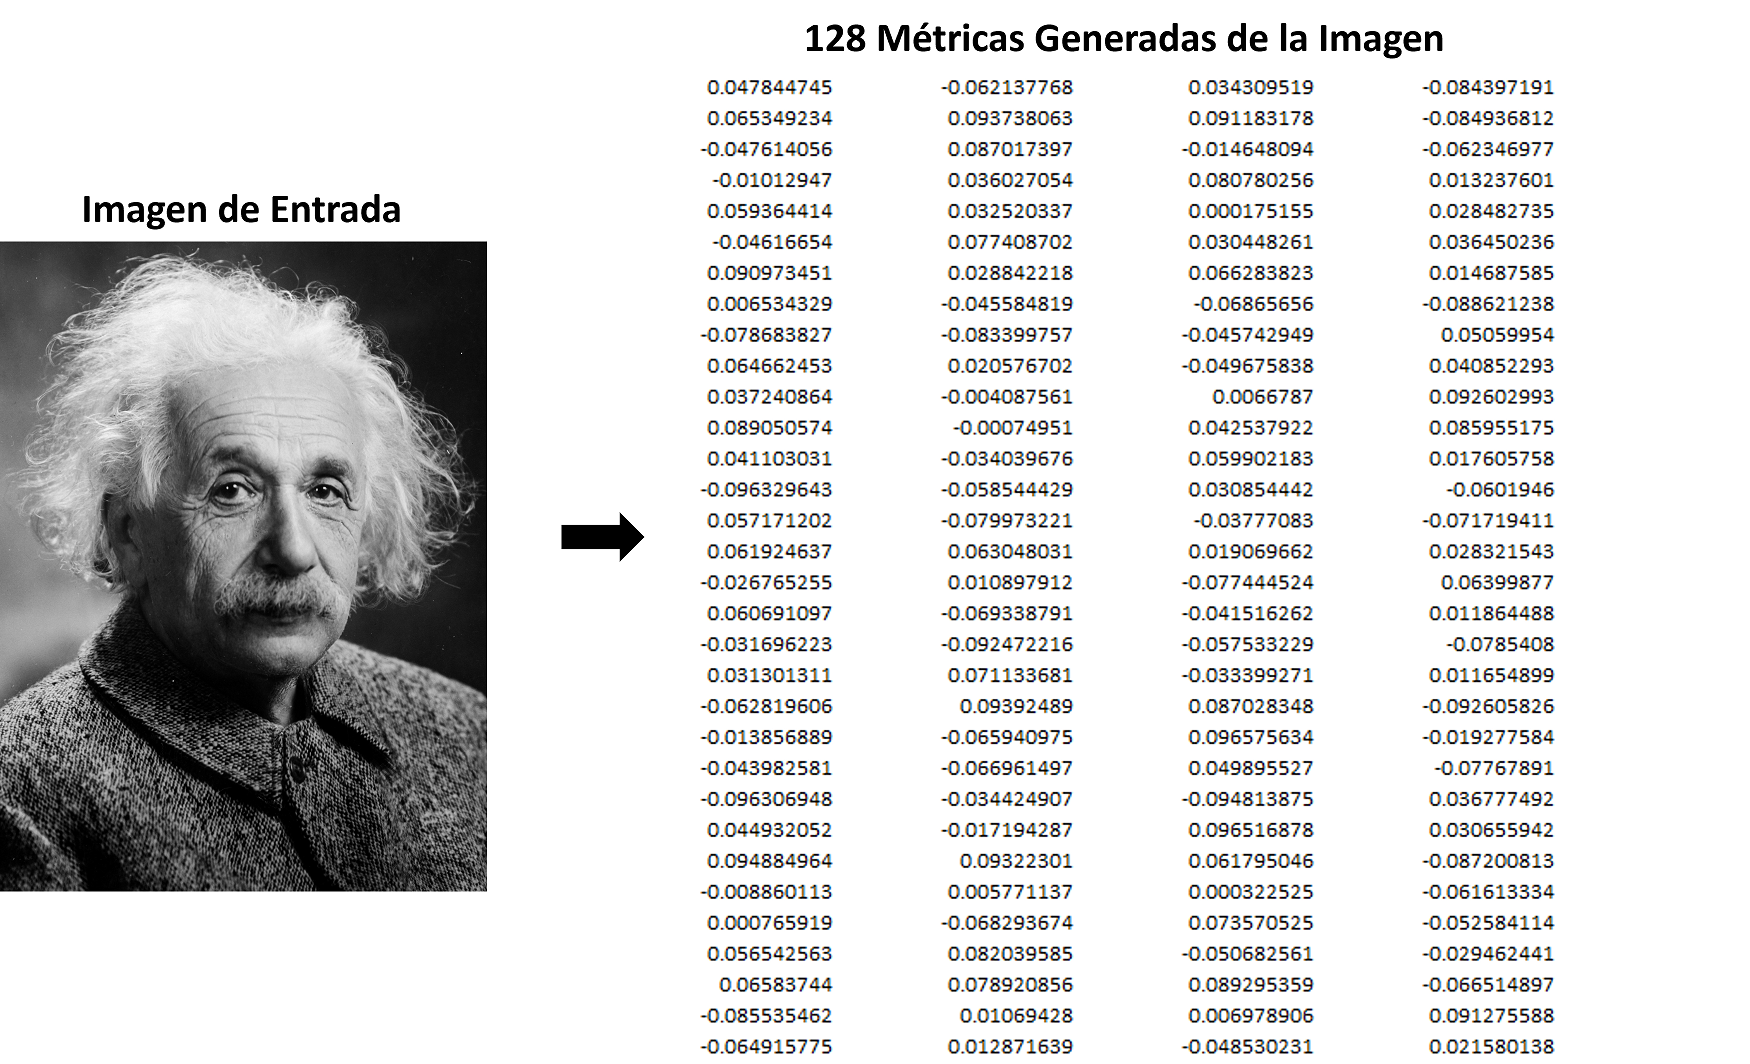

### 4. Identificando a la persona en la imagen codificada (GPU).

El último paso consiste en la identificación del nombre de la persona a la que le pertenece el rostro. Es en este punto donde la metodología propuesta demuestra ser muy efectiva, ya que sólo se necesita entrenar un modelo de clasificación que asocie las 128 métricas a las caras que se quieran identificar. El problema clasificación puede ser tan simple como un problema binario donde se quiere saber si un rostro es o no de cierta persona, o un problema multiclase donde comparamos en una base de datos de rostros que dispongamos. El modelo utilizado puede ser, por ejemplo, una red neuronal MLP, aunque también es muy común el uso de algoritmos de Machine Learning como _Support Vector Machines (SVM)_.

Para realizar una prueba completa, se busca reconocer el rostro de Albert Einstein en la icónica imagen histórica de la Universidad de los Andes donde aparece como miembro de la Junta Consultiva durante sus inicios. Las siguientes líneas requieren el uso de GPU para el aprendizaje del nuevo rostro y su identificación en una imagen diferente, por lo tanto se debe ejecutar en Google Colaboratory solicitando los recursos correspondientes (no es necesario que ejecute el código de los anteriores numerales, el siguiente código es autocontenido). Consulte la lectura _"Lectura 4: Uso de Google Colab para ejecución de Jupyter Notebooks con GPU"_ para guiarse en el proceso en caso de dudas.

In [ ]:
#Se requiere la instalación de estos paquetes en la instancia de Google Colab con GPU
!pip install cmake
!pip install dlib
!pip install face-recognition

In [ ]:
import numpy as np
import urllib
import cv2
from PIL import Image, ImageDraw
from IPython.display import display
import face_recognition

In [ ]:
req = urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/d/d3/Albert_Einstein_Head.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, cv2.IMREAD_COLOR) 
scale_percent = 25
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('einstein_scaled.jpg', image)

In [ ]:
#Se descarga la imagen del repositorio de la Universidad
!wget https://www.uniandes.edu.co/sites/default/files/styles/1_1_large/public/2024-09/Einstein_mision.webp

In [ ]:
# Se carga la imagen de muestra y se aprende cómo reconocerla. 
# Debe aplicar las siguientes dos líneas para cada rostro que quiera reconocer.
einstein_image = face_recognition.load_image_file("einstein_scaled.jpg")
einstein_face_encoding = face_recognition.face_encodings(einstein_image)[0]

# Se crean los arreglos con los encodings de cada rostro y sus nombres.
# La longitud del arreglo debe coincidir con la cantidad de rostros a reconocer.
known_face_encodings = [
    einstein_face_encoding
]
known_face_names = [
    "Albert Einstein"
]
print('Learned encoding for', len(known_face_encodings), 'images.')

In [ ]:
# Se carga la imagen con los rostros que se quieren reconocer
unknown_image = face_recognition.load_image_file("Einstein_mision.webp")

# Encuentra todas las caras y sus encodings en la imagen solicitada
face_locations = face_recognition.face_locations(unknown_image)
face_encodings = face_recognition.face_encodings(unknown_image, face_locations)

# Convierte la imagen a formato PIL para que se pueda dibujar sobre esta con el paquete Pillow
# Revise http://pillow.readthedocs.io/ para más información sobre PIL/Pillow
pil_image = Image.fromarray(unknown_image)
# Se crea una instancia Pillow ImageDraw Draw 
draw = ImageDraw.Draw(pil_image)

# Se revisa cada cara encontrada en la imagen solicitada
for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    # Se revisa si la cara coincide con alguna de las caras conocidas. Si no, la etiqueta como desconocida
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Unknown"

    # O por otro lado, se selecciona la cara cuyas métricas estén más cercanas a la cara evaluada
    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
        name = known_face_names[best_match_index]

    # Dibuja un cuadrado alrededor del rostro usando el módulo Pillow
    draw.rectangle(((left, top), (right, bottom)), outline=(0, 0, 255))

    # Se dibuja una etiqueta con el nombre identificado debajo del rostro
    text_width, text_height = draw.textsize(name)
    draw.rectangle(((left, bottom - text_height - 10), (right, bottom)), fill=(0, 0, 255), outline=(0, 0, 255))
    draw.text((left + 2, bottom - text_height - 5), name, fill=(255, 255, 255, 255))


# Se remueve la instancia de Draw Pillow para ahorro de memoria
del draw

# Se grafica la imagen resultante
display(pil_image)

### Actividad calificada por el personal

1. Utilice el código para entrenar al algoritmo para reconocer el rostro de dos personas de su equipo o el de dos personas famosas en una imagen donde se encuentren ustedes (o los famosos) y otras personas. Debería retornar una imagen donde se reconozca a las personas y las demás caras sean etiquetadas como desconocidas [40 puntos].

2. Ponga a prueba el algoritmo de reconocimiento facial con tres imágenes donde aparezca con diferentes gestos, iluminación, ángulos de la cara (por ejemplo, pruebe inclinando bastante el rostro) y/o use accesorios (por ejemplo, bufanda, gafas oscuras, etc.). Procure que al menos una de las imágenes falle en reconocerlo y analice posibles razones por las que el algoritmo no lo reconoció [60 puntos].

Recuerde que además de su código, debe mandar las imágenes para que su envío se pueda reproducir.